In [4]:
# ============================================
# PHẦN 4: PHÂN TÍCH CỘNG ĐỒNG TRONG MẠNG
# ============================================

import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import community as community_louvain  # Louvain
from networkx.algorithms import community as nx_comm
import seaborn as sns
sns.set(style="whitegrid")
edges = pd.read_csv('data/edges.csv')
nodes = pd.read_csv('data/nodes.csv')

In [5]:
# --- Tạo graph directed ---
G = nx.DiGraph()
G.add_nodes_from(nodes['id'])
for _, row in edges.iterrows():
    G.add_edge(row['source'], row['target'], weight=row['weight'])

# --- Largest weakly connected component, chuyển sang undirected ---
largest_cc = max(nx.weakly_connected_components(G), key=len)
G_largest = G.subgraph(largest_cc).to_undirected()

=== K-core decomposition ===
Top 10 node theo k-core:
                    node  k_core
212         @chiphan4651       2
414             @nht1823       2
649        @quốckhâm-z9s       2
242         @CafeCao-d9u       2
178         @diethuy1788       2
420         @fcmobilevn.       2
277      @tinhphamvan742       2
499           @HuyLeo203       2
118  @PhuongNguyen-hp3ek       2
290           @vyhoa6397       2


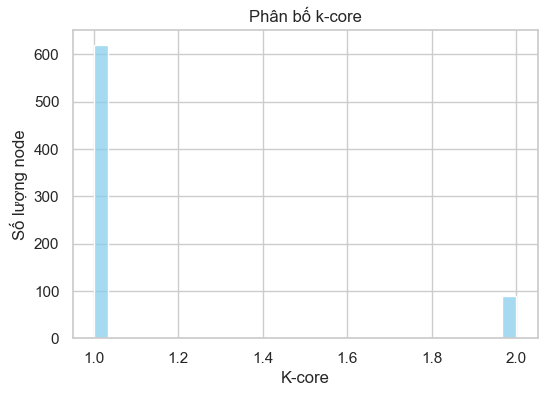

In [6]:
# --- 1. K-CORE ---
print("=== K-core decomposition ===")
k_core_dict = nx.core_number(G_largest)  # k-core number cho mỗi node
k_core_df = pd.DataFrame(list(k_core_dict.items()), columns=['node','k_core'])
print("Top 10 node theo k-core:")
print(k_core_df.sort_values('k_core', ascending=False).head(10))

plt.figure(figsize=(6,4))
sns.histplot(k_core_df['k_core'], bins=30, color='skyblue')
plt.title("Phân bố k-core")
plt.xlabel("K-core")
plt.ylabel("Số lượng node")
plt.show()

In [10]:
# --- 2. PHÁT HIỆN CỘNG ĐỒNG ---
print("\n=== Phát hiện cộng đồng ===")

# --- 2a. Louvain method (max modularity) ---
partition = community_louvain.best_partition(G_largest)  # dictionary node -> community
modularity = community_louvain.modularity(partition, G_largest)
print(f"Louvain: số lượng cộng đồng = {len(set(partition.values()))}, modularity = {modularity:.4f}")

louvain_df = pd.DataFrame(list(partition.items()), columns=['node','community'])

# --- 2b. Girvan-Newman method (bằng edge betweenness) ---
# Chỉ lấy top 5 level để tránh quá nhiều community
# Chuyển node sang string
G_largest = nx.relabel_nodes(G_largest, lambda x: str(x))

comp = nx_comm.girvan_newman(G_largest)
limited = []
for communities in comp:
    limited.append(tuple(sorted(c) for c in communities))
    if len(limited) >= 5:
        break


# Ví dụ in level 3
communities_level3 = limited[2]
print(f"Girvan-Newman level 3: số lượng community = {len(communities_level3)}")


=== Phát hiện cộng đồng ===
Louvain: số lượng cộng đồng = 27, modularity = 0.8810
Girvan-Newman level 3: số lượng community = 4



Girvan-Newman modularity across levels:
   level  num_communities  modularity
0      1                2    0.484391
1      2                3    0.640372
2      3                4    0.680810
3      4                5    0.724049
4      5                6    0.746198


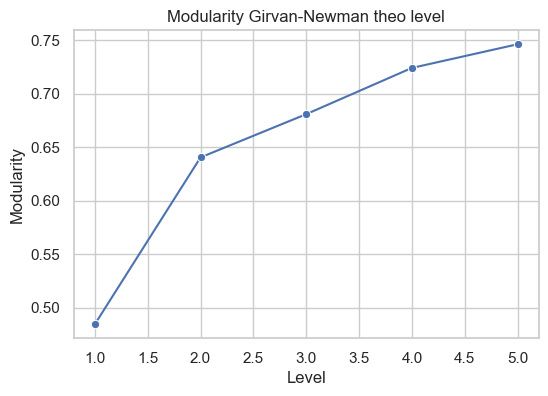

In [11]:
# --- 3. So sánh modularity ---
modularity_gn = []
for i, comms in enumerate(limited):
    comm_dict = {}
    for idx, c in enumerate(comms):
        for node in c:
            comm_dict[node] = idx
    mod = community_louvain.modularity(comm_dict, G_largest)
    modularity_gn.append((i+1, len(comms), mod))

mod_df = pd.DataFrame(modularity_gn, columns=['level','num_communities','modularity'])
print("\nGirvan-Newman modularity across levels:")
print(mod_df)

plt.figure(figsize=(6,4))
sns.lineplot(data=mod_df, x='level', y='modularity', marker='o')
plt.title("Modularity Girvan-Newman theo level")
plt.xlabel("Level")
plt.ylabel("Modularity")
plt.show()

In [16]:
# ============================================
# PHẦN 4: PHÂN TÍCH CỘNG ĐỒNG & EXPORT GEXF
# ============================================

import networkx as nx
import community as community_louvain  # Louvain

# --- 1. Giả sử bạn đã có graph G_largest (undirected) ---

# --- 2. Tính k-core ---
k_core_dict = nx.core_number(G_largest)  # node -> k-core

# --- 3. Phát hiện cộng đồng Louvain ---
partition = community_louvain.best_partition(G_largest)  # node -> community

# --- 4. Gán attribute cho node ---
for n in G_largest.nodes():
    G_largest.nodes[n]['k_core'] = float(k_core_dict.get(n, 1))
    G_largest.nodes[n]['community'] = partition.get(n, 0)

# --- 5. Xuất file GEXF ---
nx.write_gexf(G_largest, 'output/youtube_graph.gexf')
print("Đã xuất youtube_graph.gexf, sẵn sàng mở Gephi")

# --- 6. Gợi ý trực quan hóa trên Gephi ---
print("\nHướng dẫn trực quan hóa trong Gephi:")
print("- Mở Gephi → File → Open → chọn youtube_graph.gexf")
print("- Layout: ForceAtlas2 hoặc Fruchterman-Reingold → Run layout")
print("- Node color: Partition → community → Apply")
print("- Node size: Ranking → k_core → Size → Apply")
print("- Có thể lọc/Highlight node theo community hoặc k_core")
print("- Xuất ảnh: File → Export → PDF/PNG để chèn báo cáo")


Đã xuất youtube_graph.gexf, sẵn sàng mở Gephi

Hướng dẫn trực quan hóa trong Gephi:
- Mở Gephi → File → Open → chọn youtube_graph.gexf
- Layout: ForceAtlas2 hoặc Fruchterman-Reingold → Run layout
- Node color: Partition → community → Apply
- Node size: Ranking → k_core → Size → Apply
- Có thể lọc/Highlight node theo community hoặc k_core
- Xuất ảnh: File → Export → PDF/PNG để chèn báo cáo
